In [8]:
from utils import *
import utils

In [9]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [10]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu', input_dim=S)
        self.W2 = tf.keras.layers.Dense(50, 'relu', input_dim=50)
        self.W3 = tf.keras.layers.Dense(A, input_dim=50)
    
    def __call__(self, x):
        x = self.W1(x)
        x = self.W2(x)
        return self.W3(x)
    
create_nn = lambda S,A: Model(S,A)

In [11]:
def epsilon_greedy(q, epsilon): # [1,A], []
    ''' q values [1,A] -> [] action '''
    if np.random.rand() < epsilon: return np.random.choice(q.shape[1])
    else: return np.squeeze(np.argmax(q, axis=-1))

In [12]:
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.Qnn = create_nn(self.S, self.A) # Q online network
        self.Tnn = create_nn(self.S, self.A) # Target network
        self.Tnn.set_weights( self.Qnn.get_weights() )
        self.double_dqn = True
        self.batch_size = 32 # batch size
        self.swap_iters = 100 # if iter > this: swap/copy networks
        self.iter, self._step = 1, 1 # iteration to construct epsilon and swap netowrks
        self.D = deque(maxlen=2000) # experience replay buffer
        # calculate moving std + mean using batch normalization
        self.batch_norm = tf.keras.layers.BatchNormalization(momentum=0.95, axis=0, scale=False, center=False)
        # usage: self.bn(x, trainable=True/False), where x.shape = [b,X]
        # if trainable==False: (x - mean) / std, where mean, std are moving avg got when using trainable==True
        # if True: (x - x.mean(axis=-1) / x.std(axis=-1) # ([b,X] -[b]) / [b]
    
    def first_step(self, s, sdict): # [1,S]
        a = np.random.randint(self.A) # [] (random move)
        self.s, self.a = s, a # save prev state + action + q value
        # init plot values if not inited
#         sdict['loss'] += 0
#         sdict['action0'] += 0
#         sdict['action1'] += 0
#         sdict['Qaction0'] += 0
#         sdict['Qaction1'] += 0
#         sdict['epsilon'] += 0
        return a
        
    def step(self, r, s, sdict): # [], [1,S]
        # append tuple to experience replay
        self.D.append([self.s, self.a, r, s, False]) # s, a, r, s', done(bool)
        if len(self.D) < self.batch_size: loss = 0
        else: loss = self.update_weights(self.batch_size)
#         sdict['loss'] += float(loss)
        # copy Q network to T network
        if self.iter > self.swap_iters:
            self.Tnn.set_weights( self.Qnn.get_weights() )
            self.iter = 0
        # update other vars
        f = lambda _from, _to, _in, _step: (_from - _step*((_from-_to)/_in))
        self.epsilon = f(0.5, 0, 4000, self._step) # from eps to eps in num steps
        self.epsilon = max(self.epsilon, 0.01)
#         sdict['epsilon'] += self.epsilon
        self.iter += 1; self._step += 1
        # select action from Q network
        q = self.Qnn(s) # [1,A]
#         sdict['Qaction0'] += float(q[0,0])
#         sdict['Qaction1'] += float(q[0,1])
        a = epsilon_greedy(q, self.epsilon) # []
#         sdict['action'+str(a)] += 1
        # remember last state + action
        self.s, self.a = s, a
        return a
    
    def update_weights(self, b): # batch size
        # select batch from experience replay
        B = random.sample(self.D, b) # random batch from experience replay
        # calculate Q values in s'
        S = np.squeeze(np_map(lambda x: x[3], B)) # [b,S]
        R = np.squeeze(np_map(lambda x: x[2], B)) # [b]
        # calculate new Q values in s when doing a action
        mask = ~np.squeeze(np_map(lambda x: x[4], B)).astype(bool) # [b] (mask if it is last action)
        Q = self.Tnn(S)
        Qa = R + self.y * np.max(Q, axis=-1) * mask # [b] (bellman error)
        # leave other action values the same in s
        S = np.squeeze(np_map(lambda x: x[0], B)) # [b,S]
        A = np.squeeze(np_map(lambda x: x[1], B)).astype(int) # [b]
        Q = self.Qnn(S).numpy() # [b,A]
        Q[np.arange(b),A] = Qa # [b,A]
        # _ = self.batch_norm(Q, training=True) # update running mean, std
        # Q = self.batch_norm(Q, training=False) # [b,A] use running mean, std
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            Q_hat = self.Qnn(S) # [e,A]
            each_loss = tf.reduce_sum( (Q-Q_hat)**2 , axis=-1 ) # [e]
            loss = tf.reduce_mean(each_loss) # avg of all examples
        # calc + update gradients
        nn_vars = self.Qnn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))
        return loss
    
    def last_step(self, r, sdict):
        self.D.append([self.s, self.a, r, self.s, True]) # s, a, r, s', done

In [16]:
agent_fn = lambda S,A,env_fn=None: Agent(num_states=S, num_actions=A, lr=1e-3, gamma=0.99)

In [7]:
test_agent_on_simple_games(agent_fn, 'DQN', game_dict={'CartPole-v1':500})

True

In [17]:
d = pd.DataFrame()
exp = Experiment(env, agent_fn(S,A))
df = exp.run(1000, 1, name='')
d = d.append(df)

KeyboardInterrupt: 

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


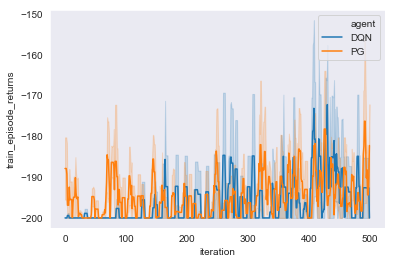

In [117]:
df = load_my_benchmark('Taxi-v2')
plot_df(df, rolling_mean=5)

In [109]:
def plot_df(df, y='train_episode_returns', confidence=68, yname='', rolling_mean=None):
    # yname is used as y axis name when y is list
    if isinstance(y, list):
        out = pd.DataFrame()
        for col in y:
            d = df[ [col, 'iteration'] ]
            d.rename(columns={col:yname}, inplace=True)
            d.insert(0, 'agent', col) # add additional col w/ name
            out = out.append(d)
        y = yname
        df = out
    else:
        pass
    if rolling_mean is not None:
        out = df.copy()
        out[y] = out[y].rolling(rolling_mean).mean()
    else:
        out = df
    return sns.lineplot(x='iteration', y=y, hue='agent', ci=confidence, data=out)

In [67]:
d = pd.DataFrame(exp.D)

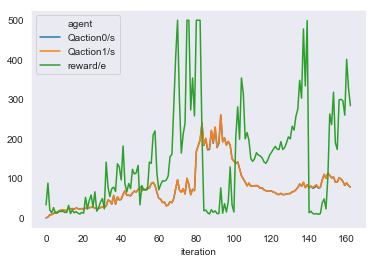

In [71]:
ax = plot_df(d, y=['Qaction0/s', 'Qaction1/s', 'reward/e'], confidence=68)

In [292]:
# df = exp.run(1000, 1, name='')
# d = d.append(df)